## Spatio-Temporal GAM

In [103]:
from pygam import LinearGAM, s, te, f
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

In [104]:
# training and test data
train_df = pd.read_csv("train_df.csv")
test_df = pd.read_csv("test_df.csv")

In [105]:
features = ['PAR', 'SST', 'log_CHL', 'MLD', 'Salinity', 'DO', 'log_N', 'log_P', 'Fe_avg',
            'coord1', 'coord2', 'coord3', 'time_sin', 'time_cos']
target = 'log_y'

In [106]:
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

In [145]:
X_train

PAR        SST   log_CHL        MLD  Salinity       DO     log_N  \
0    48.498001  26.086876 -0.846321  13.669296    34.331   85.128  0.538567   
1    43.810997  20.894375 -0.010877  12.974066    33.103  177.987 -0.152932   
2    55.973999  26.219999 -1.431482  46.160884    34.988  107.299 -1.386735   
3    54.632000  30.250000 -1.175834  33.011963    36.066  194.919 -1.062148   
4    55.620998  26.306250 -0.606427  38.735352    35.010   32.179  0.813266   
..         ...        ...       ...        ...       ...      ...       ...   
672  39.632000  25.278334 -0.925029  67.395896    34.187    3.458 -1.086668   
673  60.292000  25.939375 -1.545441  32.048210    37.080  144.022 -1.008774   
674  59.488998  24.709999 -1.261818  29.187469    34.981  119.424 -1.140753   
675  54.773998  29.570000 -1.556658  35.536552    34.757  152.996 -0.806622   
676  34.403999  29.564999 -0.837553  39.390944    33.648    2.373  0.612875   

        log_P    Fe_avg    coord1    coord2    coord3  time_sin  time_cos  
0   -0.433680  0.144716  0.603904  0.336851  0.722379 -0.866025 -0.500000  
1   -0.944830  0.955586  0.655847 -0.695924 -0.292497 -0.866025 -0.500000  
2   -1.189523  0.191298  0.386711 -0.345463  0.855050 -0.866025 -0.500000  
3   -0.874338  0.226984  0.549606 -0.812409 -0.194742 -0.866025 -0.500000  
4   -0.245860  0.113547  0.000075 -0.642780  0.766051 -0.866025 -0.500000  
..        ...       ...       ...       ...       ...       ...       ...  
672 -0.361844  0.209275  0.240896 -0.799271  0.550577  0.500000 -0.866025  
673 -1.356547  0.517506  0.349262 -0.672682 -0.652316  0.500000 -0.866025  
674 -1.153213  0.286532  0.386711 -0.345463  0.855050  0.500000 -0.866025  
675 -1.272385  0.241941  0.294253  0.547856  0.783115  0.500000 -0.866025  
676 -0.087884  0.225440  0.184056 -0.936287  0.299149  0.500000 -0.866025  

[677 rows x 14 columns]

### Build GAM

In [8]:
# smooths for each env var
env_smooths = [s(i) for i in range(9)]

# spatial: tensor spline over 3D coordinates
spatial_smooth = te(9, 10, 11)

# temporal: tensor spline over sin and cos of time
temporal_smooth = te(12, 13)

In [16]:
# model = env + spatial + temporal
model = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + 
    te(9, 10, 11) + 
    te(12, 13))
gam = model.fit(X_train, y_train)

In [17]:
model.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     65.6761
Link Function:                     IdentityLink Log Likelihood:                                  -788.8509
Number of Samples:                          677 AIC:                                             1711.0541
                                                AICc:                                            1725.8652
                                                GCV:                                                0.4147
                                                Scale:                                               0.343
                                                Pseudo R-Squared:                                   0.3875
Feature Function                  Lam

/var/folders/hj/_2__yt6s2vd0smglfwx30m0w0000gn/T/ipykernel_79228/3470139634.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  model.summary()


### Prediction

In [20]:
y_pred = gam.predict(X_test)

In [27]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")

Test MSE: 0.3259
Test R²: 0.4012


### Plot the result

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.xlabel('True Log(NF) (μmol N m-2 d-1)', fontsize=12)
plt.ylabel('Predicted Log(NF) (μmol N m-2 d-1)', fontsize=12)
plt.title('Spatio-Temporal GAM', fontsize=14)
plt.text(0.05, 0.95, f'R² = {r2:.2f}\nMSE = {mse:.2f}',
         transform=plt.gca().transAxes,
         fontsize=12,
         verticalalignment='top',
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

plt.grid(True)
plt.tight_layout()
plt.show()

### Add Interactions

In [29]:
import seaborn as sns
# 查看目标变量分布
sns.histplot(train_df['log_y'], kde=True)

<Axes: xlabel='log_y', ylabel='Count'>

In [31]:
# 检查变量间相关性
sns.heatmap(train_df[features + [target]].corr(), annot=True)

<Axes: >

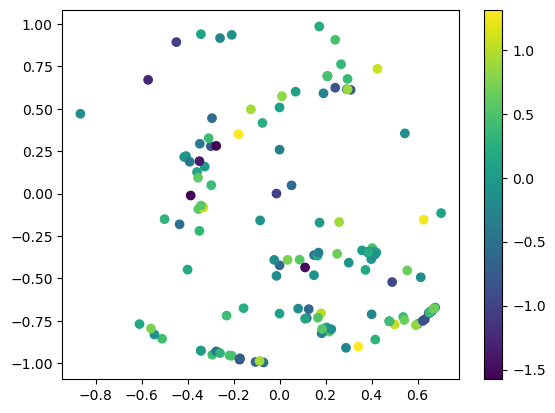

In [32]:
residuals = y_test - y_pred
plt.scatter(X_test['coord1'], X_test['coord2'], c=residuals)
plt.colorbar()  # 空间残差图

In [33]:
residuals = y_train - model.predict(X_train)
plt.scatter(X_train['SST'] * X_train['PAR'], residuals)
plt.xlabel("SST * PAR")
plt.ylabel("Residuals")

Text(0, 0.5, 'Residuals')

Text(0, 0.5, 'Residuals')

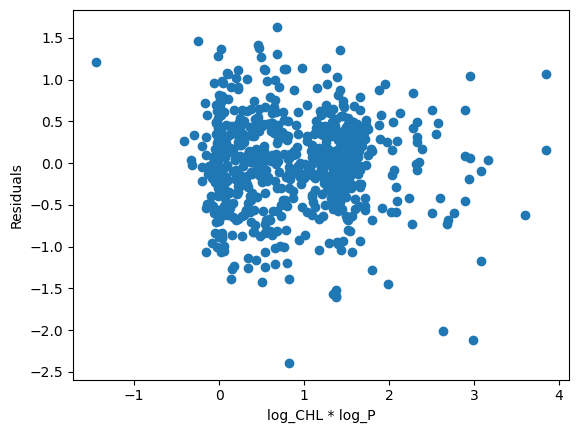

In [34]:
residuals = y_train - model.predict(X_train)
plt.scatter(X_train['log_CHL'] * X_train['log_P'], residuals)
plt.xlabel("log_CHL * log_P")
plt.ylabel("Residuals")

Text(0, 0.5, 'Residuals')

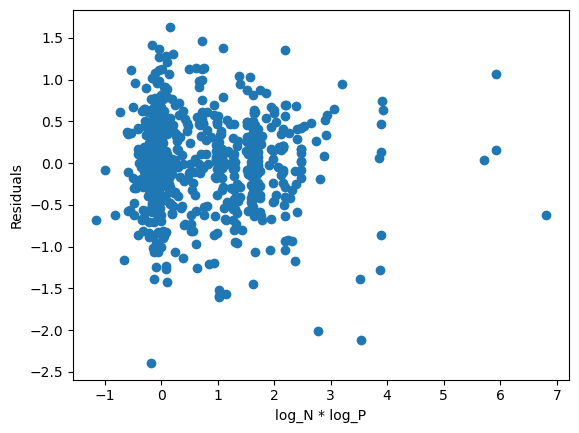

In [35]:
residuals = y_train - model.predict(X_train)
plt.scatter(X_train['log_N'] * X_train['log_P'], residuals)
plt.xlabel("log_N * log_P")
plt.ylabel("Residuals")

Text(0, 0.5, 'Residuals')

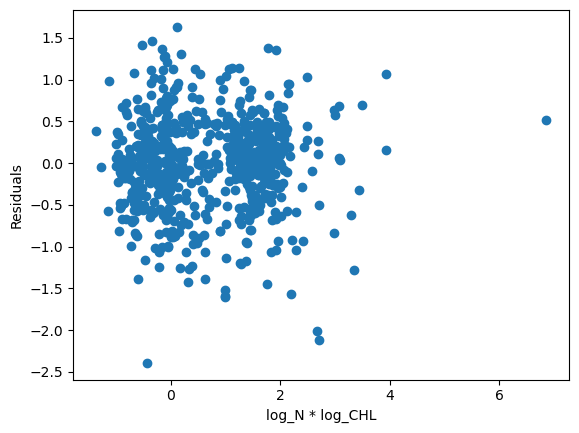

In [36]:
residuals = y_train - model.predict(X_train)
plt.scatter(X_train['log_N'] * X_train['log_CHL'], residuals)
plt.xlabel("log_N * log_CHL")
plt.ylabel("Residuals")

Text(0, 0.5, 'Residuals')

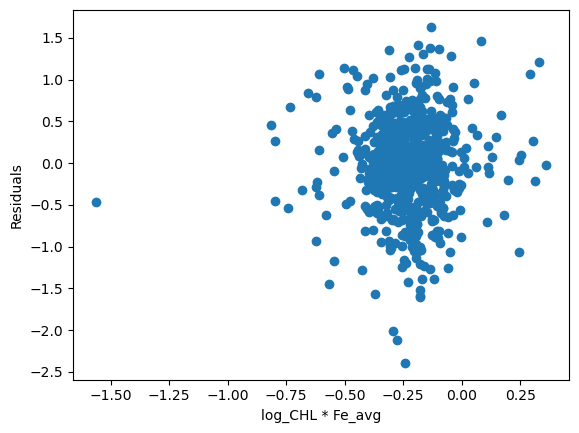

In [37]:
residuals = y_train - model.predict(X_train)
plt.scatter(X_train['log_CHL'] * X_train['Fe_avg'], residuals)
plt.xlabel("log_CHL * Fe_avg")
plt.ylabel("Residuals")

Text(0, 0.5, 'Residuals')

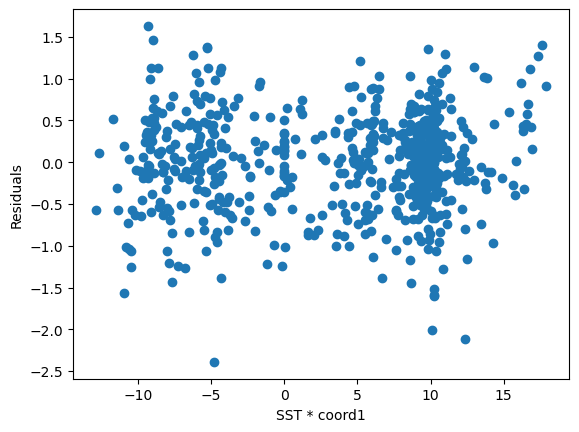

In [38]:
residuals = y_train - model.predict(X_train)
plt.scatter(X_train['SST'] * X_train['coord1'], residuals)
plt.xlabel("SST * coord1")
plt.ylabel("Residuals")

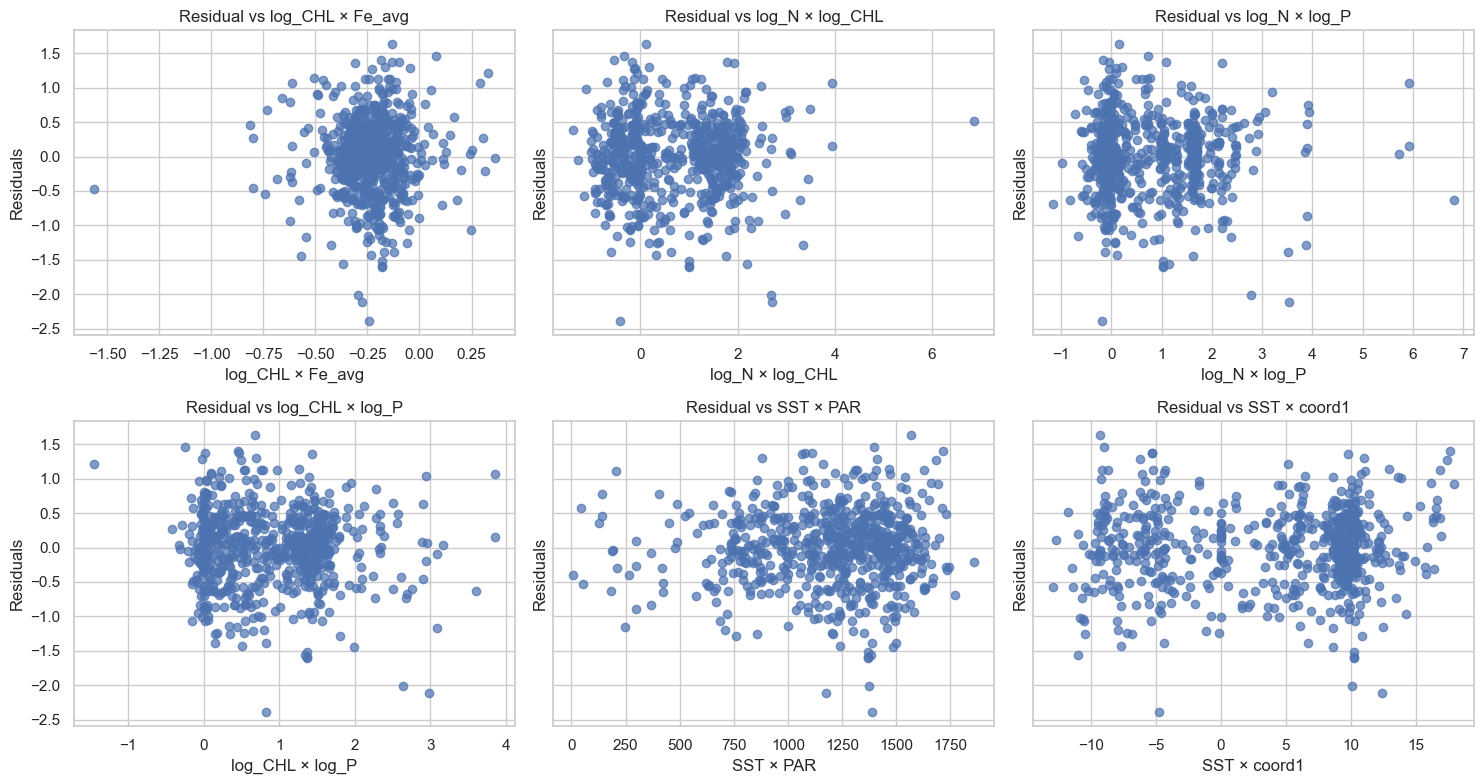

In [70]:
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

residuals = y_train - model.predict(X_train)

# features group
x_vars = [
    X_train['log_CHL'] * X_train['Fe_avg'],
    X_train['log_N'] * X_train['log_CHL'],
    X_train['log_N'] * X_train['log_P'],
    X_train['log_CHL'] * X_train['log_P'],
    X_train['SST'] * X_train['PAR'],
    X_train['SST'] * X_train['coord1']
    
]

x_labels = [
    "log_CHL × Fe_avg",
    "log_N × log_CHL",
    "log_N × log_P",
    "log_CHL × log_P",
    "SST × PAR",
    "SST × coord1"
]

# subplot
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.flatten()

for i in range(6):
    axes[i].scatter(x_vars[i], residuals, alpha=0.7)
    axes[i].set_xlabel(x_labels[i])
    axes[i].set_ylabel("Residuals")
    axes[i].set_title(f"Residual vs {x_labels[i]}")

plt.tight_layout()
plt.savefig("feature_group.png")
plt.show()


#### Partial Dependence 

### Space Smooth 空间 (coord1, coord2, coord3）

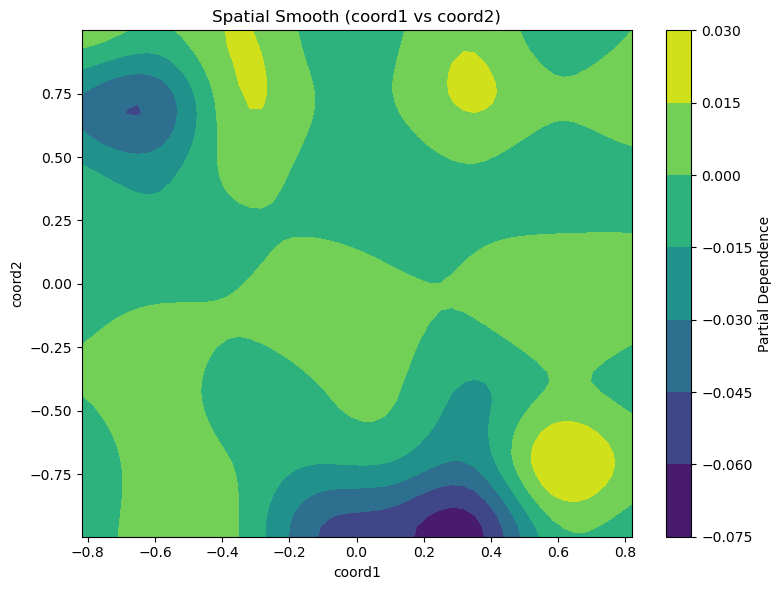

In [71]:
spatial_term_idx = 9  # 因为空间项在第9项

# 固定 coord3（高度），在 coord1 和 coord2 上建网格
coord1 = np.linspace(X_train[features[9]].min(), X_train[features[9]].max(), 50)
coord2 = np.linspace(X_train[features[10]].min(), X_train[features[10]].max(), 50)
coord1_grid, coord2_grid = np.meshgrid(coord1, coord2)

X_grid = np.zeros((50*50, X_train.shape[1]))
X_grid[:, 9] = coord1_grid.ravel()
X_grid[:, 10] = coord2_grid.ravel()
X_grid[:, 11] = X_train[features[11]].mean()  # 固定 coord3 为平均值

# Predict
pdep = gam.partial_dependence(term=spatial_term_idx, X=X_grid).reshape(50, 50)

# Contour Plot
plt.figure(figsize=(8,6))
cp = plt.contourf(coord1_grid, coord2_grid, pdep, cmap='viridis')
plt.colorbar(cp, label='Partial Dependence')
plt.xlabel('coord1')
plt.ylabel('coord2')
plt.title('Spatial Smooth (coord1 vs coord2)')
plt.tight_layout()
plt.show()


### Temporal Smooth

In [68]:
import numpy as np
import matplotlib.pyplot as plt

temporal_term_idx = 10  # 因为是第10项（从0开始数）

# 构建12个月份角度
months = np.arange(1, 13)
angles = 2 * np.pi * months / 12
time_sin = np.sin(angles)
time_cos = np.cos(angles)

# 构造输入
X_grid = np.zeros((12, X_train.shape[1]))
X_grid[:, 12] = time_sin
X_grid[:, 13] = time_cos

# 获取 partial dependence
pdep, confi = gam.partial_dependence(term=temporal_term_idx, X=X_grid, width=.95)

# 画图
plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
ax.plot(angles, pdep, marker='o', label='Partial Dependence')
ax.fill_between(angles, confi[:, 0], confi[:, 1], alpha=0.2, label='95% CI')
ax.set_xticks(angles)
ax.set_xticklabels([f'Month {m}' for m in months])
ax.set_title('Temporal Partial Dependence (Polar Plot)')
plt.legend()
plt.show()



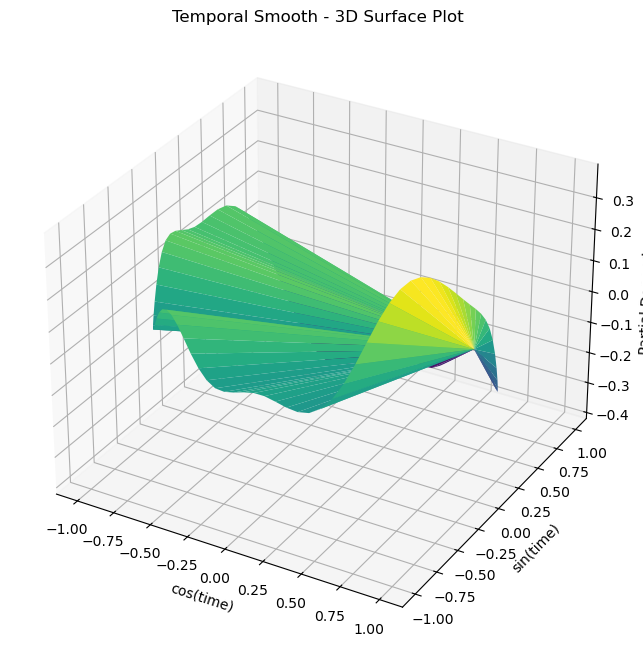

In [70]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# 构建角度网格
angles = np.linspace(0, 2 * np.pi, 100)
time_sin = np.sin(angles)
time_cos = np.cos(angles)

X_grid = np.zeros((100, X_train.shape[1]))
X_grid[:, 12] = time_sin
X_grid[:, 13] = time_cos

pdep = gam.partial_dependence(term=temporal_term_idx, X=X_grid)

# 画图
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(time_cos, time_sin, pdep, cmap=cm.viridis)
ax.set_xlabel('cos(time)')
ax.set_ylabel('sin(time)')
ax.set_zlabel('Partial Dependence')
ax.set_title('Temporal Smooth - 3D Surface Plot')
plt.show()


### Merge

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Temporal Smooth: Polar Plot ----------
temporal_term_idx = 10  # te(12, 13)

months = np.arange(1, 13)
angles = 2 * np.pi * months / 12
time_sin = np.sin(angles)
time_cos = np.cos(angles)

X_temp = np.zeros((12, X_train.shape[1]))
X_temp[:, 12] = time_sin
X_temp[:, 13] = time_cos

pdep_temp, confi_temp = gam.partial_dependence(term=temporal_term_idx, X=X_temp, width=0.95)

# ---------- Spatial Smooth: Contour Plot ----------
spatial_term_idx = 9  # te(9,10,11)

lat = np.linspace(-60, 60, 100)
lon = np.linspace(0, 360, 180)
lat_grid, lon_grid = np.meshgrid(lat, lon)

coord1 = np.sin(np.radians(lat_grid))
coord2 = np.sin(np.radians(lon_grid)) * np.cos(np.radians(lat_grid))
coord3 = -np.cos(np.radians(lon_grid)) * np.cos(np.radians(lat_grid))

X_spatial = np.zeros((lat_grid.size, X_train.shape[1]))
X_spatial[:, 9] = coord1.ravel()
X_spatial[:, 10] = coord2.ravel()
X_spatial[:, 11] = coord3.ravel()

pdep_spatial = gam.partial_dependence(term=spatial_term_idx, X=X_spatial).reshape(lat_grid.shape)

# ---------- Residuals ----------
y_pred = gam.predict(X_test)
residuals = y_test - y_pred

In [117]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# --- (a) Polar plot: Temporal Smooth (第1行左图)
ax1 = fig.add_subplot(gs[0, 0], polar=True)
ax1.plot(angles, pdep_temp, marker='o', label='Partial Dependence')
ax1.fill_between(angles, confi_temp[:, 0], confi_temp[:, 1], alpha=0.2, label='95% CI')
ax1.set_xticks(angles)
ax1.set_xticklabels([f'Month {m}' for m in months])
ax1.set_title('(a) Temporal Smooth')
ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.15))

# --- (b) Spatial Smooth (第1行右图)
ax2 = fig.add_subplot(gs[0, 1])
c = ax2.contourf(lon_grid, lat_grid, pdep_spatial, cmap='coolwarm', levels=20)
plt.colorbar(c, ax=ax2, label='Partial Dependence')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('(b) Spatial Smooth')

# --- (c) Residual Scatter Plot (第2行横跨两列)
ax3 = fig.add_subplot(gs[1, :])
ax3.scatter(y_pred, residuals, alpha=0.6)
ax3.axhline(0, color='gray', linestyle='--')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Residual (True - Pred)')
ax3.set_title('(c) Prediction Residuals')

plt.tight_layout()
plt.savefig("gam_smooth.png")
plt.show()

In [39]:
from pygam import LinearGAM, s, te

model_interaction = LinearGAM(
    s(0) + s(1) + te(0, 1, n_splines=10) +          # SST和PAR的非线性交互
    s(2) + s(6) + te(2, 6,n_splines=10) + 
    s(2) + s(7) + te(2, 7,n_splines=10) +          # log_CHL, log_N, log_P的交互
    te(2, 8,n_splines=10) +                         # log_CHL和Fe_avg的交互
    s(3) + s(4) + s(5) +               # MLD, Salinity, DO
    te(9,10,n_splines=10)+s(11) +                    # 空间交互
    te(12, 13,n_splines=10)
)  



In [40]:
gam = model_interaction.fit(X_train, y_train)

In [42]:
residuals = y_train - model_interaction.predict(X_train)
plt.scatter(model_interaction.predict(X_train), residuals)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")

Text(0, 0.5, 'Residuals')

In [47]:
from sklearn.metrics import r2_score, mean_squared_error

# 测试集评估
y_pred_test = gam.predict(X_test)

In [58]:
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Test MSE: {test_mse:.4f}")
print(f"Test R²: {test_r2:.4f}")

Test MSE: 0.2817
Test R²: 0.4822


In [66]:
len(y_test)

169

In [63]:
# sedaborn
sns.set(style='white', context='notebook')
plt.figure(figsize=(8, 6))
# scatter plot
sc = plt.scatter(
    y_test, y_pred_test,cmap='viridis',
    alpha=0.8, s=50
)

# ideal fit
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--'
)

# MSE + R²
plt.text(
    0.05, 0.95, f'MSE={test_mse:.2f}\n$R^2$={test_r2:.2f}\nn=169',
    fontsize=10,
    verticalalignment='top',
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray')
)

plt.title("Spatio-Temporal GAM", fontsize=13)
plt.xlabel("Observed Log(NF) ($\mu$mol N m$^{-2}$ d$^{-1}$)", fontsize=11)
plt.ylabel("Predicted Log(NF) ($\mu$mol N m$^{-2}$ d$^{-1}$)", fontsize=11)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("GAM_model.png", dpi=300)
plt.show()


/var/folders/hj/_2__yt6s2vd0smglfwx30m0w0000gn/T/ipykernel_79228/4256293268.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = plt.scatter(


In [110]:
print(X_train.shape)  # 查看 X_train 的维度
print(X_train.columns)  # 如果 X_train 是 DataFrame，查看列名称


(677, 14)
Index(['PAR', 'SST', 'log_CHL', 'MLD', 'Salinity', 'DO', 'log_N', 'log_P',
       'Fe_avg', 'coord1', 'coord2', 'coord3', 'time_sin', 'time_cos'],
      dtype='object')


In [112]:
print(type(X_train))  # 打印出 X_train 的类型


<class 'pandas.core.frame.DataFrame'>


In [127]:
X_train_np = X_train.to_numpy()  # 显式转换为 NumPy 数组

In [128]:
import matplotlib.pyplot as plt
import numpy as np
from pygam import LinearGAM, s, te

# 假设模型已拟合（gam = model_interaction.fit(X_train, y_train)）

# (1) 绘制单个变量的部分依赖图
def plot_partial_dependence(gam, feature_idx, X, feature_name, n_points=100):
    # 生成均匀覆盖特征范围的网格
    x_grid = np.linspace(X[:, feature_idx].min(), X[:, feature_idx].max(), n_points)
    # 固定其他特征为均值/众数
    XX = np.ones((n_points, X.shape[1])) * X.mean(axis=0)
    XX[:, feature_idx] = x_grid
    # 预测并计算置信区间
    preds = gam.predict_mu(XX)
    conf_intervals = gam.confidence_intervals(XX, width=0.95)
    
    # 绘图
    plt.figure()
    plt.plot(x_grid, preds, 'b-', lw=2, label='Marginal Effect')
    plt.fill_between(x_grid, conf_intervals[:, 0], conf_intervals[:, 1], alpha=0.2, color='blue')
    plt.xlabel(feature_name)
    plt.ylabel('Partial Dependence on N2 Fixation')
    plt.title(f'Nonlinear Effect of {feature_name}')
    plt.grid(True)
    plt.show()

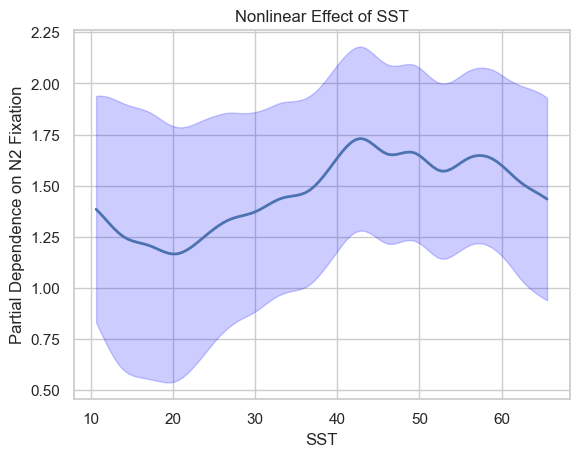

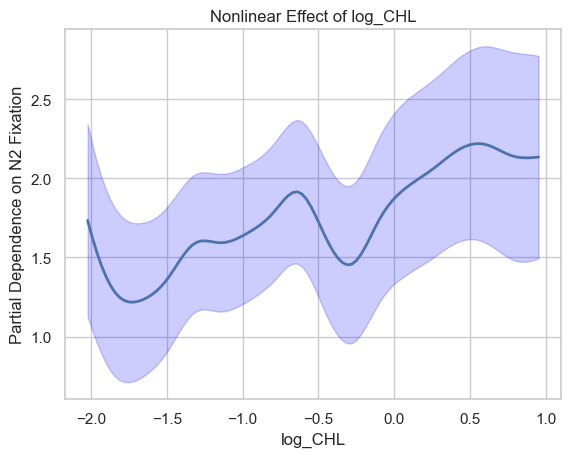

In [129]:
# 示例：可视化SST（假设是第0列）和log_CHL（第2列）
plot_partial_dependence(gam, 0, X_train_np, 'SST')
plot_partial_dependence(gam, 2, X_train_np, 'log_CHL')

In [140]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
def plot_partial_dependence_ax(gam, feature_idx, X, feature_name, ax, n_points=100):
    
    x_grid = np.linspace(X[:, feature_idx].min(), X[:, feature_idx].max(), n_points)
    XX = np.ones((n_points, X.shape[1])) * X.mean(axis=0)
    XX[:, feature_idx] = x_grid
    preds = gam.predict_mu(XX)
    conf_intervals = gam.confidence_intervals(XX, width=0.95)

    # derivative
    grads = np.gradient(preds, x_grid)

    # threshold
    threshold_indices = np.where(np.abs(grads) < 0.01)[0]  # 阈值可以调节

    if len(threshold_indices) > 0:
        threshold_idx = threshold_indices[0]
        threshold_x = x_grid[threshold_idx]
        threshold_y = preds[threshold_idx]
        ax.axvline(threshold_x, color='red', linestyle='--', label='Threshold')

    peaks, _ = find_peaks(np.abs(grads))
    if len(peaks) > 0:
        peak_idx = peaks[np.argmax(np.abs(grads[peaks]))]
        peak_x = x_grid[peak_idx]
        peak_y = preds[peak_idx]
        ax.plot(peak_x, peak_y, 'ro', label='Turning Point')

    # plot
    ax.plot(x_grid, preds, 'b-', lw=2)
    ax.fill_between(x_grid, conf_intervals[:, 0], conf_intervals[:, 1], alpha=0.2, color='blue')
    ax.set_xlabel(feature_name)
    ax.set_ylabel('Partial Dependence')
    ax.grid(True)
    ax.legend()



In [141]:
# features
feature_names = ['PAR', 'SST', 'log_CHL', 'MLD', 'Salinity', 'DO', 
                 'log_N', 'log_P', 'Fe_avg', 'coord1', 'coord2', 'coord3', 
                 'time_sin', 'time_cos']

# plot
fig, axes = plt.subplots(5, 3, figsize=(18, 24)) 
axes = axes.flatten()  # 展平成1维数组，方便循环

for idx, feature_name in enumerate(feature_names):
    plot_partial_dependence_ax(gam, idx, X_train_np, feature_name, axes[idx])
for j in range(len(feature_names), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("PDP.png")
plt.show()

In [130]:
# (2) 交互效应可视化（如SST和PAR的交互）
def plot_interaction(gam, feature_idx1, feature_idx2, X, names, n_points=20):
    x1_grid = np.linspace(X[:, feature_idx1].min(), X[:, feature_idx1].max(), n_points)
    x2_grid = np.linspace(X[:, feature_idx2].min(), X[:, feature_idx2].max(), n_points)
    xx1, xx2 = np.meshgrid(x1_grid, x2_grid)
    XX = np.ones((n_points * n_points, X.shape[1])) * X.mean(axis=0)
    XX[:, feature_idx1] = xx1.ravel()
    XX[:, feature_idx2] = xx2.ravel()
    preds = gam.predict_mu(XX).reshape(n_points, n_points)
    
    # 绘图
    plt.figure()
    contour = plt.contourf(xx1, xx2, preds, levels=20, cmap='viridis')
    plt.colorbar(contour, label='N2 Fixation Rate')
    plt.xlabel(names[0])
    plt.ylabel(names[1])
    plt.title(f'Interaction between {names[0]} and {names[1]}')
    plt.show()

plot_interaction(gam, 0, 1, X_train_np, ['SST', 'PAR'])

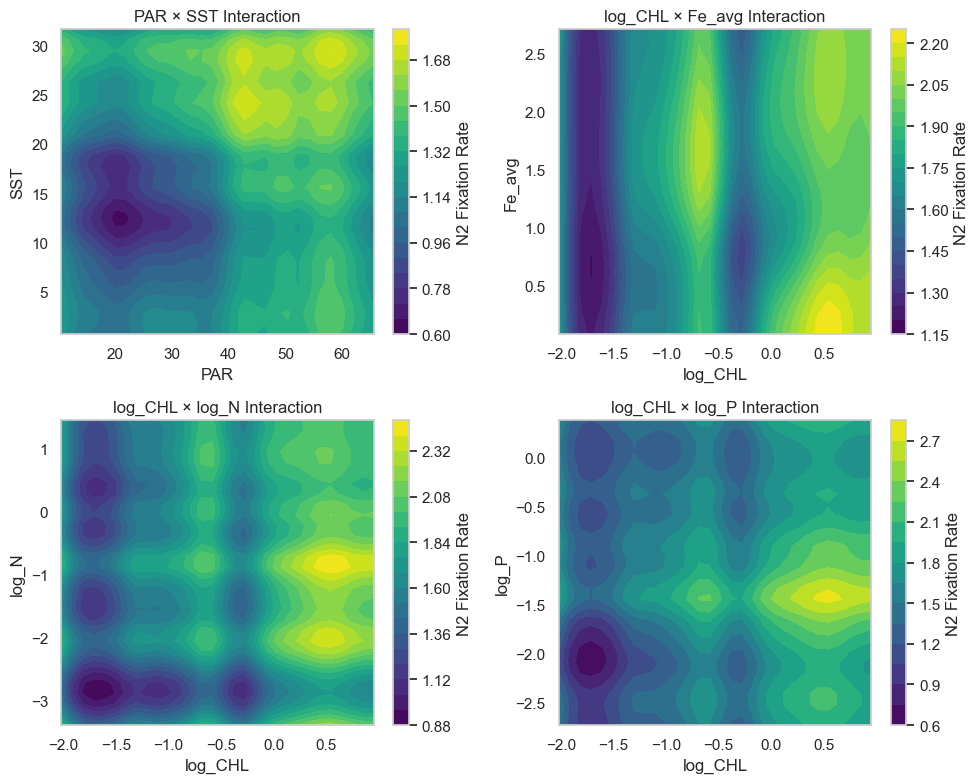

In [150]:
import numpy as np
import matplotlib.pyplot as plt

def plot_interaction_grid(gam, X_train_np, feature_pairs, feature_names):
    """
    Plot multiple interaction effects in a 2x2 grid
    
    Parameters:
    - gam: Your fitted GAM model
    - X_train_np: Training data as numpy array
    - feature_pairs: List of tuples containing feature indices to plot
    - feature_names: List of feature names for labeling
    """
    plt.figure(figsize=(10,8))
    
    for i, (idx1, idx2) in enumerate(feature_pairs, 1):
        # Create grid for current pair
        n_points = 30
        x1_grid = np.linspace(X_train_np[:, idx1].min(), X_train_np[:, idx1].max(), n_points)
        x2_grid = np.linspace(X_train_np[:, idx2].min(), X_train_np[:, idx2].max(), n_points)
        xx1, xx2 = np.meshgrid(x1_grid, x2_grid)
        
        # Create prediction matrix
        XX = np.ones((n_points * n_points, X_train_np.shape[1])) * X_train_np.mean(axis=0)
        XX[:, idx1] = xx1.ravel()
        XX[:, idx2] = xx2.ravel()
        preds = gam.predict_mu(XX).reshape(n_points, n_points)
        
        # Create subplot
        plt.subplot(2, 2, i)
        contour = plt.contourf(xx1, xx2, preds, levels=20, cmap='viridis')
        plt.colorbar(contour, label='N2 Fixation Rate')
        plt.xlabel(feature_names[idx1])
        plt.ylabel(feature_names[idx2])
        plt.title(f'{feature_names[idx1]} × {feature_names[idx2]} Interaction')
    
    plt.tight_layout()
    plt.savefig("gam_inter.png")
    plt.show()

# Define the feature pairs to plot (using indices)
feature_pairs = [
    (0, 1),    # PAR (0) and SST (1)
    (2, 8),    # log_CHL (2) and Fe_avg (8)
    (2, 6),    # log_CHL (2) and log_N (6)
    (2, 7)     # log_CHL (2) and log_P (7)
]

feature_names = [
    'PAR', 'SST', 'log_CHL', 'MLD', 'Salinity', 'DO', 
    'log_N', 'log_P', 'Fe_avg', 'coord1', 'coord2', 'coord3', 
    'time_sin', 'time_cos'
]

# Generate the plot grid
plot_interaction_grid(gam, X_train_np, feature_pairs, feature_names)

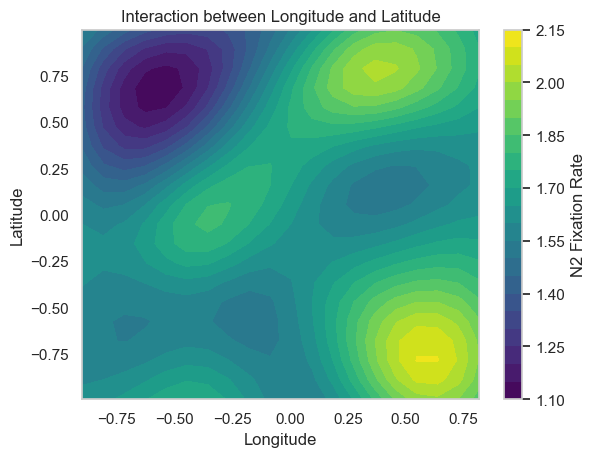

In [131]:
# 绘制空间效应（经纬度）
plot_interaction(gam, 9, 10, X_train_np, ['Longitude', 'Latitude'])

# 绘制时间效应（年、月）
plot_partial_dependence(gam, 12, X_train_np, 'Year')
plot_partial_dependence(gam, 13, X_train_np, 'Month')

### Global Map Plot

PAR_gridded/PAR_01.npz
SST_gridded/SST_01.npz
CHL_gridded/CHL_01.npz
MLD_gridded/MLD_01.npz
Salinity_gridded/Salinity_01.npz
DO_gridded/DO_01.npz
nitrate_gridded/nitrate_01.npz
phosphate_gridded/phosphate_01.npz
Fe_gridded/Fe_01.npz


/var/folders/hj/_2__yt6s2vd0smglfwx30m0w0000gn/T/ipykernel_79228/2269497547.py:28: RuntimeWarning: invalid value encountered in log10
  data = np.log10(data)  # log10变换


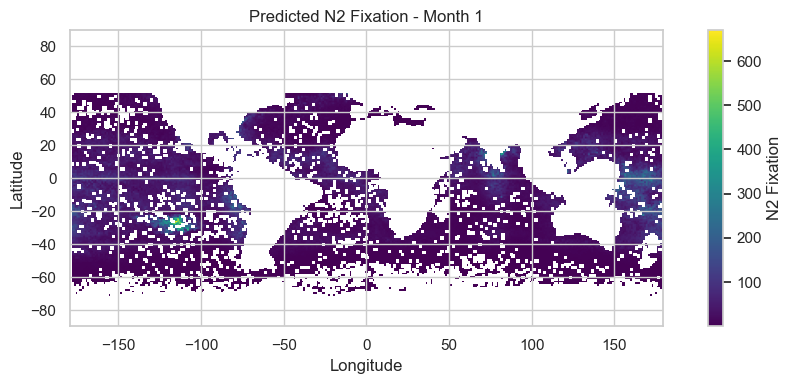

PAR_gridded/PAR_02.npz
SST_gridded/SST_02.npz
CHL_gridded/CHL_02.npz
MLD_gridded/MLD_02.npz
Salinity_gridded/Salinity_02.npz
DO_gridded/DO_02.npz
nitrate_gridded/nitrate_02.npz
phosphate_gridded/phosphate_02.npz
Fe_gridded/Fe_02.npz


PAR_gridded/PAR_03.npz
SST_gridded/SST_03.npz
CHL_gridded/CHL_03.npz
MLD_gridded/MLD_03.npz
Salinity_gridded/Salinity_03.npz
DO_gridded/DO_03.npz
nitrate_gridded/nitrate_03.npz
phosphate_gridded/phosphate_03.npz
Fe_gridded/Fe_03.npz


PAR_gridded/PAR_04.npz
SST_gridded/SST_04.npz
CHL_gridded/CHL_04.npz
MLD_gridded/MLD_04.npz
Salinity_gridded/Salinity_04.npz
DO_gridded/DO_04.npz
nitrate_gridded/nitrate_04.npz
phosphate_gridded/phosphate_04.npz
Fe_gridded/Fe_04.npz


PAR_gridded/PAR_05.npz
SST_gridded/SST_05.npz
CHL_gridded/CHL_05.npz
MLD_gridded/MLD_05.npz
Salinity_gridded/Salinity_05.npz
DO_gridded/DO_05.npz
nitrate_gridded/nitrate_05.npz
phosphate_gridded/phosphate_05.npz
Fe_gridded/Fe_05.npz


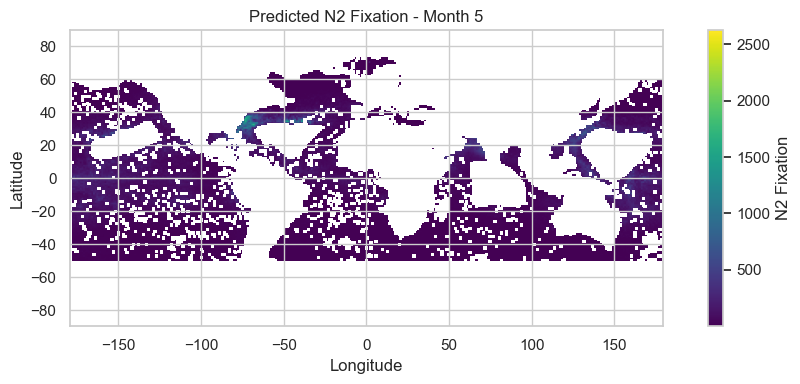

PAR_gridded/PAR_06.npz
SST_gridded/SST_06.npz
CHL_gridded/CHL_06.npz
MLD_gridded/MLD_06.npz
Salinity_gridded/Salinity_06.npz
DO_gridded/DO_06.npz
nitrate_gridded/nitrate_06.npz
phosphate_gridded/phosphate_06.npz
Fe_gridded/Fe_06.npz


PAR_gridded/PAR_07.npz
SST_gridded/SST_07.npz
CHL_gridded/CHL_07.npz
MLD_gridded/MLD_07.npz
Salinity_gridded/Salinity_07.npz
DO_gridded/DO_07.npz
nitrate_gridded/nitrate_07.npz
phosphate_gridded/phosphate_07.npz
Fe_gridded/Fe_07.npz


PAR_gridded/PAR_08.npz
SST_gridded/SST_08.npz
CHL_gridded/CHL_08.npz
MLD_gridded/MLD_08.npz
Salinity_gridded/Salinity_08.npz
DO_gridded/DO_08.npz
nitrate_gridded/nitrate_08.npz
phosphate_gridded/phosphate_08.npz
Fe_gridded/Fe_08.npz


PAR_gridded/PAR_09.npz
SST_gridded/SST_09.npz
CHL_gridded/CHL_09.npz
MLD_gridded/MLD_09.npz
Salinity_gridded/Salinity_09.npz
DO_gridded/DO_09.npz
nitrate_gridded/nitrate_09.npz
phosphate_gridded/phosphate_09.npz
Fe_gridded/Fe_09.npz


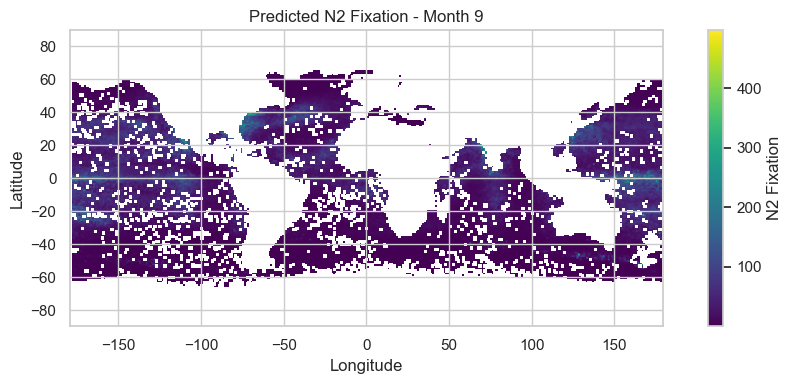

PAR_gridded/PAR_10.npz
SST_gridded/SST_10.npz
CHL_gridded/CHL_10.npz
MLD_gridded/MLD_10.npz
Salinity_gridded/Salinity_10.npz
DO_gridded/DO_10.npz
nitrate_gridded/nitrate_10.npz
phosphate_gridded/phosphate_10.npz
Fe_gridded/Fe_10.npz


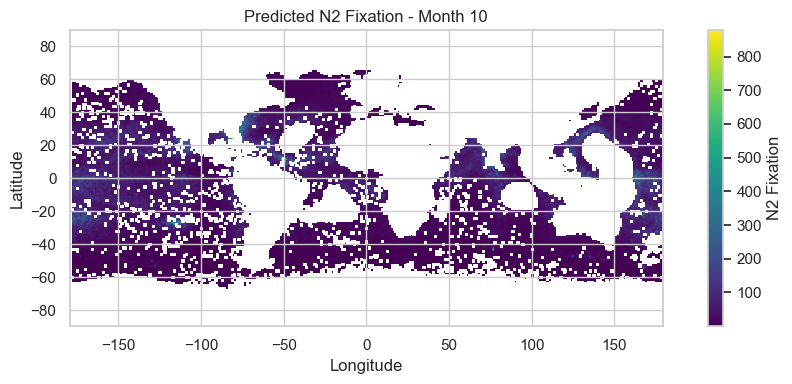

PAR_gridded/PAR_11.npz
SST_gridded/SST_11.npz
CHL_gridded/CHL_11.npz
MLD_gridded/MLD_11.npz
Salinity_gridded/Salinity_11.npz
DO_gridded/DO_11.npz
nitrate_gridded/nitrate_11.npz
phosphate_gridded/phosphate_11.npz
Fe_gridded/Fe_11.npz


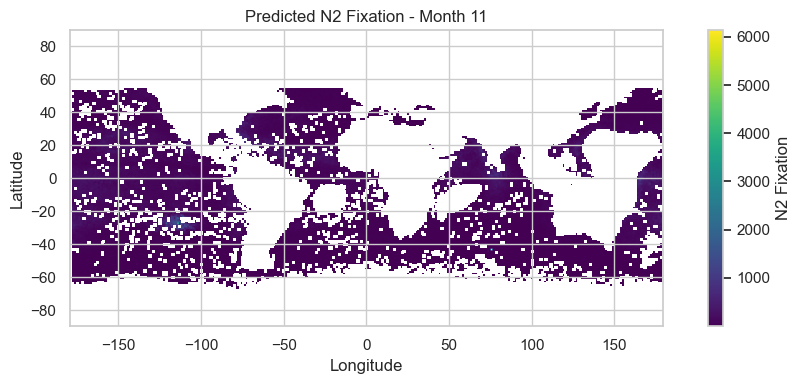

PAR_gridded/PAR_12.npz
SST_gridded/SST_12.npz
CHL_gridded/CHL_12.npz
MLD_gridded/MLD_12.npz
Salinity_gridded/Salinity_12.npz
DO_gridded/DO_12.npz
nitrate_gridded/nitrate_12.npz
phosphate_gridded/phosphate_12.npz
Fe_gridded/Fe_12.npz


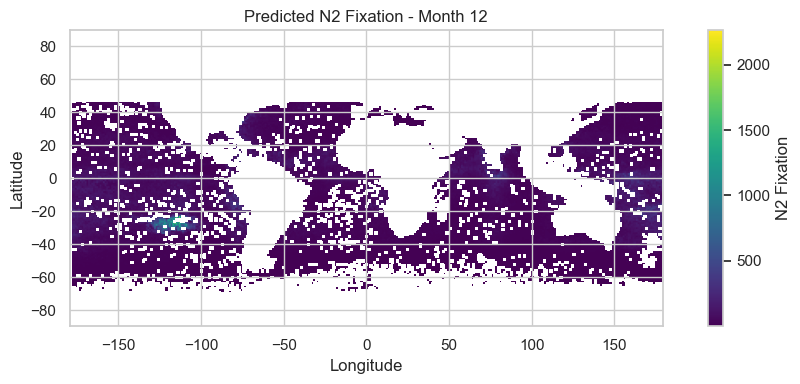

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import joblib 
import os

var_names = ['PAR', 'SST', 'CHL', 'MLD', 'Salinity', 'DO', 'nitrate', 'phosphate', 'Fe']
input_folder = './'  # 每个变量一个文件夹：CHL_gridded, PAR_gridded 等
log_vars = ['CHL', 'nitrate', 'phosphate'] 

target_lat = np.linspace(-89.5, 89.5, 180)
target_lon = np.linspace(-179.5, 179.5, 360)
lon_mesh, lat_mesh = np.meshgrid(target_lon, target_lat)

# === 12 months ===
monthly_predictions = []

for month in range(1, 13):
    feature_stack = []

    for var in var_names:
        filepath = os.path.join(f"{var}_gridded", f"{var}_{month:02d}.npz")
        print(filepath)
        data = np.load(filepath)[var if var != 'CHL' else 'CHL']
        #print(data.shape)
        if data.shape != (180, 360):
            data = data.T
        if var in log_vars:
            data = np.log10(data)  # log10变换
        feature_stack.append(data)

    # 转为 (N, 13) 的输入矩阵
    # 每个feature是 (180, 360)，展开成 (64800,)
    features = [f.ravel() for f in feature_stack]
    # 加入坐标特征
    coord1 = np.sin(np.radians(lat_mesh)).ravel()
    coord2 = (np.sin(np.radians(lon_mesh)) * np.cos(np.radians(lat_mesh))).ravel()
    coord3 = (-np.cos(np.radians(lon_mesh)) * np.cos(np.radians(lat_mesh))).ravel()
    time_cos = np.cos(2 * np.pi * month / 12) * np.ones((180, 360)).ravel()
    time_sin = np.sin(2 * np.pi * month / 12) * np.ones((180, 360)).ravel()

    # all features 
    X = np.vstack(features + [coord1, coord2, coord3, time_sin, time_cos]).T  # shape (64800, 14)

    valid_mask = ~np.isnan(X).any(axis=1)  # shape=(64800,)

    # not NaN 
    X_valid = X[valid_mask]

    # 模型预测
    y_pred_log = gam.predict(X_valid)
    #y_pred = np.power(10, y_pred_log)  # 还原 log10 -> 真实值

    full_pred_flat = np.full(180 * 360, np.nan)
    full_pred_flat[valid_mask] = np.power(10, y_pred_log)
    # 还原为2D地图
    pred_map = full_pred_flat.reshape(180, 360)

    monthly_predictions.append(pred_map)

    # 可视化
    plt.figure(figsize=(10, 4))
    plt.imshow(pred_map, origin='lower', cmap='viridis', extent=[-179.5, 179.5, -89.5, 89.5])
    plt.colorbar(label='N2 Fixation')
    plt.title(f'Predicted N2 Fixation - Month {month}')
    plt.xlabel('Longitude'); plt.ylabel('Latitude')
    plt.tight_layout()
    plt.show()

In [78]:
#### ------- Fill with the neighborhood mean (3x3 grid) -------- ####
import numpy as np
from scipy.ndimage import generic_filter
from matplotlib.colors import LogNorm

def nanmean_filter(values):
    """计算非nan值的均值"""
    valid = values[~np.isnan(values)]
    return np.mean(valid) if valid.size > 0 else np.nan

# annual avg
annual_avg = np.nanmean(np.stack(monthly_predictions), axis=0)

# fill: 3x3 sliding window
filled_once = annual_avg.copy()
nan_mask1 = np.isnan(filled_once)
smoothed1 = generic_filter(filled_once, nanmean_filter, size=3, mode='constant', cval=np.nan)
filled_once[nan_mask1] = smoothed1[nan_mask1]

# 3x3 sliding window
filled_twice = filled_once.copy()
nan_mask2 = np.isnan(filled_twice)
smoothed2 = generic_filter(filled_twice, nanmean_filter, size=3, mode='constant', cval=np.nan)
filled_twice[nan_mask2] = smoothed2[nan_mask2]

annual_filled = filled_twice

plt.figure(figsize=(12, 5))
plt.imshow(
    annual_filled, 
    origin='lower', 
    cmap='viridis', 
    extent=[-179.5, 179.5, -89.5, 89.5],
    norm=LogNorm(vmin=1, vmax=1000)
)

cbar = plt.colorbar(ticks=[1, 10, 100, 1000])
cbar.set_label('Annual Mean N2 Fixation ($\mu$mol N m$^{-2}$ d$^{-1}$)')

plt.title('Annual N2 Fixation Prediction (Spatio-Temporal GAM)')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

/var/folders/hj/_2__yt6s2vd0smglfwx30m0w0000gn/T/ipykernel_79228/1902098379.py:12: RuntimeWarning: Mean of empty slice
  annual_avg = np.nanmean(np.stack(monthly_predictions), axis=0)


In [79]:
# grid
lat = np.linspace(-89.5, 89.5, 180)
lon = np.linspace(-179.5, 179.5, 360)
# save as .npz
np.savez('annual_gam.npz', lat=lat, lon=lon, n2fix=annual_filled)


In [80]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# === load data ===
data = np.load('annual_gam.npz')
lat = data['lat']
lon = data['lon']
annual_filled = data['n2fix']

# === ploy ===
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=proj)

img = ax.imshow(
    annual_filled,
    origin='lower',
    cmap='viridis',
    extent=[lon.min(), lon.max(), lat.min(), lat.max()],
    transform=proj,
    norm=LogNorm(vmin=1, vmax=1000)
)
# land and boundary
ax.coastlines(resolution='110m', linewidth=1)
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)

# label
ax.set_xticks([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150], crs=proj)
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=proj)

ax.set_xticklabels(['150°W','120°W','90°W','60°W','30°W','0°','30°E','60°E','90°E','120°E','150°E'])
ax.set_yticklabels(['90°S','60°S','30°S','0°','30°N','60°N','90°N'])

ax.gridlines(draw_labels=False, linestyle='--', alpha=0.4)

# colorbar
cbar = plt.colorbar(img, ax=ax, orientation='vertical', shrink=0.7, pad=0.05,ticks=[1, 10, 100, 1000])

cbar.set_label('Annual Mean N2 Fixation ($\mu$mol N m$^{-2}$ d$^{-1}$)')

plt.title('Spatio-Temporal GAM')
plt.tight_layout()
plt.savefig("GAM_map.png", dpi=300)
plt.show()

